In this exercise, you are going to classify whether a given text belongs to one of possible classes ['BUSINESS', 'SPORTS', 'CRIME'].

you are going to use spacy for pre-processing the text, convert text to numbers and apply different classification algorithms.


In [4]:

!python -m spacy download en_core_web_lg

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.7.1/en_core_web_lg-3.7.1-py3-none-any.whl (587.7 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:

#import spacy and load the language model downloaded

import spacy
nlp = spacy.load("en_core_web_lg")

About Data: News Category Classifier
Credits: https://www.kaggle.com/code/hengzheng/news-category-classifier-val-acc-0-65

This data consists of two columns. - Text - Category
Text are the description about a particular topic.
Category determine which class the text belongs to.
we have classes mainly of 'BUSINESS', 'SPORTS', 'CRIME' and comes under Multi-class classification Problem.

In [6]:
#import pandas library
import pandas as pd


#read the dataset "news_dataset.json" provided and load it into dataframe "df"
df = pd.read_json('news_dataset.json')

#print the shape of data
print(df.shape)

#print the top5 rows
df.head()

(7500, 2)


,text,category
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS
3,This Richard Sherman Interception Literally Sh...,SPORTS
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS


In [7]:
#check the distribution of labels
df['category'].value_counts()

,count
category,
CRIME,2500
SPORTS,2500
BUSINESS,2500


In [8]:
#Add the new column which gives a unique number to each of these labels
df['label_num'] = df['category'].map({'CRIME': 0, 'SPORTS': 1, 'BUSINESS': 2})


#check the results with top 5 rows
df.head(5)

,text,category,label_num
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1
3,This Richard Sherman Interception Literally Sh...,SPORTS,1
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2


**Preprocess the text**

In [9]:
#use this utility function to preprocess the text
#1. Remove the stop words
#2. Convert to base form using lemmatisation


def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return ' '.join(filtered_tokens)

In [10]:
#create a new column "preprocessed_text" which store the clean form of given text [use apply and lambda function]

df['preprocessed_text'] = df['text'].apply(lambda text: preprocess(text))

In [11]:
#print the top 5 rows

df.head()

,text,category,label_num,preprocessed_text
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame victim say victimize newly ...
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,vegas taxpayer spend Record $ 750 million New ...
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill Weed Legalization Buzz



**Get the spacy embeddings for each preprocessed text**

In [12]:
#create a new column "vector" that store the vector representation of each pre-processed text

df['vector'] = df['preprocessed_text'].apply(lambda text: nlp(text).vector)

In [13]:
#print the top 5 rows

df.head()

,text,category,label_num,preprocessed_text,vector
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame victim say victimize newly ...,"[-0.5585511, -0.29323253, -0.9253956, 0.189389..."
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse,"[-0.73039824, -0.43196002, -1.2930516, -1.0628..."
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,vegas taxpayer spend Record $ 750 million New ...,"[-1.9413117, 0.121578515, -3.2996283, 1.511650..."
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...,"[-1.4702771, -0.685319, 0.57398, -0.31135806, ..."
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill Weed Legalization Buzz,"[-1.037173, -1.9495698, -1.7179357, 1.2975286,..."


**Train-Test splitting**

In [16]:
from sklearn.model_selection import train_test_split


#Do the 'train-test' splitting with test size of 20% with random state of 2022 and stratify sampling too
X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label_num,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.label_num
)

**Reshape the X_train and X_test so as to fit for models**

In [17]:
import numpy as np

print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)


X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (6000,)
Shape of X_test before reshaping:  (1500,)
Shape of X_train after reshaping:  (6000, 300)
Shape of X_test after reshaping:  (1500, 300)


**Attempt 1:**

use spacy glove embeddings for text vectorization.

use Decision Tree as the classifier.

print the classification report.

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

#1. creating a Decision Tree model object
clf = DecisionTreeClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       500
           1       0.70      0.71      0.70       500
           2       0.73      0.70      0.72       500

    accuracy                           0.72      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.72      0.72      0.72      1500



**Attempt 2:**

use spacy glove embeddings for text vectorization.
use MultinomialNB as the classifier after applying the MinMaxscaler.
print the classification report.

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


#doing scaling because Negative values will not pass into Naive Bayes models
scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

#1. creating a MultinomialNB model object
clf = MultinomialNB()

#2. fit with all_train_embeddings and y_train
clf.fit(scaled_train_embed , y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(scaled_test_embed)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       500
           1       0.85      0.77      0.81       500
           2       0.80      0.83      0.82       500

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500



**Attempt 3:**

use spacy glove embeddings for text vectorization.
use KNeighborsClassifier as the classifier after applying the MinMaxscaler.
print the classification report.

In [21]:

from  sklearn.neighbors import KNeighborsClassifier


#1. creating a KNN model object
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.94      0.88       500
           1       0.92      0.81      0.86       500
           2       0.88      0.87      0.88       500

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.87      1500
weighted avg       0.88      0.88      0.87      1500



**Attempt 4:**

use spacy glove embeddings for text vectorization.
use RandomForestClassifier as the classifier after applying the MinMaxscaler.
print the classification report.

In [22]:
from sklearn.ensemble import RandomForestClassifier


#1. creating a Random Forest model object
clf = RandomForestClassifier()


#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       500
           1       0.89      0.84      0.86       500
           2       0.87      0.89      0.88       500

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



**Attempt 5:**

use spacy glove embeddings for text vectorization.
use GradientBoostingClassifier as the classifier after applying the MinMaxscaler.
print the classification report.

In [23]:
from sklearn.ensemble import GradientBoostingClassifier


#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       500
           1       0.91      0.85      0.88       500
           2       0.88      0.92      0.90       500

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



**Print the confusion Matrix with the best model got**

Text(95.72222222222221, 0.5, 'Truth')

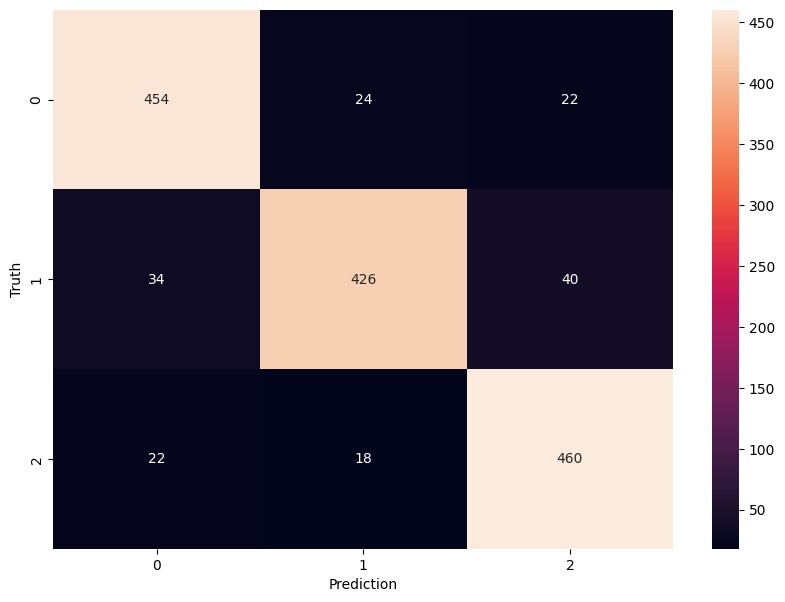

In [24]:
#finally print the confusion matrix for the best model: GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')